## Price Estimates

- Data Source: `Kaggle`

#### Tasks:
- **Cleansing**
- **EDA**
- **Merge Additional Data by geo/zip**
- **K-Means Clustering**
- **Model Price**

In [99]:
#Import Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as SPLIT
import seaborn as sns 
import matplotlib.pyplot as plt

In [100]:
#Read Data
df_raw = pd.read_csv('./realtor-data.zip.csv')
df_raw.head()

status  bed  bath  acre_lot        city        state  zip_code  \
0  for_sale  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
1  for_sale  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
2  for_sale  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
3  for_sale  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
4  for_sale  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   

   house_size prev_sold_date     price  
0       920.0            NaN  105000.0  
1      1527.0            NaN   80000.0  
2       748.0            NaN   67000.0  
3      1800.0            NaN  145000.0  
4         NaN            NaN   65000.0

## Merge Additional Data
- `Zip` or `city` as **Primary Key**
- Crime Data, Population Data, etc.

In [101]:
#Population Data
zip_df = pd.read_csv('population_by_zip_2010.csv').groupby('zipcode')['population'].max().reset_index() 
df_raw = df_raw.merge(zip_df, left_on='zip_code', right_on='zipcode', how='left') #Relational Join
df_raw.drop(columns=['zipcode'], inplace=True)

## Cleansing
- Null Values + Outliers _`viz + stats`_

In [102]:
def dist_range(df, col, z): #Output z-score ranges for data distribution of feature
    upper = round(df[col].mean() + (df[col].std())*z,4)
    lower = round(df[col].mean() - (df[col].std())*z,4)
    if lower<0:lower=0
    print(f'{col.title()} {z} Z-scores of Data: ({lower},{upper})') 

In [103]:
dist_range(df_raw, 'bath',3)
dist_range(df_raw, 'bed',3)
dist_range(df_raw, 'house_size',3)
dist_range(df_raw, 'price',3)
dist_range(df_raw, 'price',2)

Bath 3 Z-scores of Data: (0,8.2791)
Bed 3 Z-scores of Data: (0,9.5281)
House_Size 3 Z-scores of Data: (0,11278.2355)
Price 3 Z-scores of Data: (0,8250531.9648)
Price 2 Z-scores of Data: (0,5792834.0293)


In [104]:
# Remove Outliers in Analysis Columns
df = df_raw.query('bath <=6 and bed <=10 and house_size <= 4000 and state not in ["Puerto Rico", "Virgin Islands"]')
df = df.query('price<5792834')

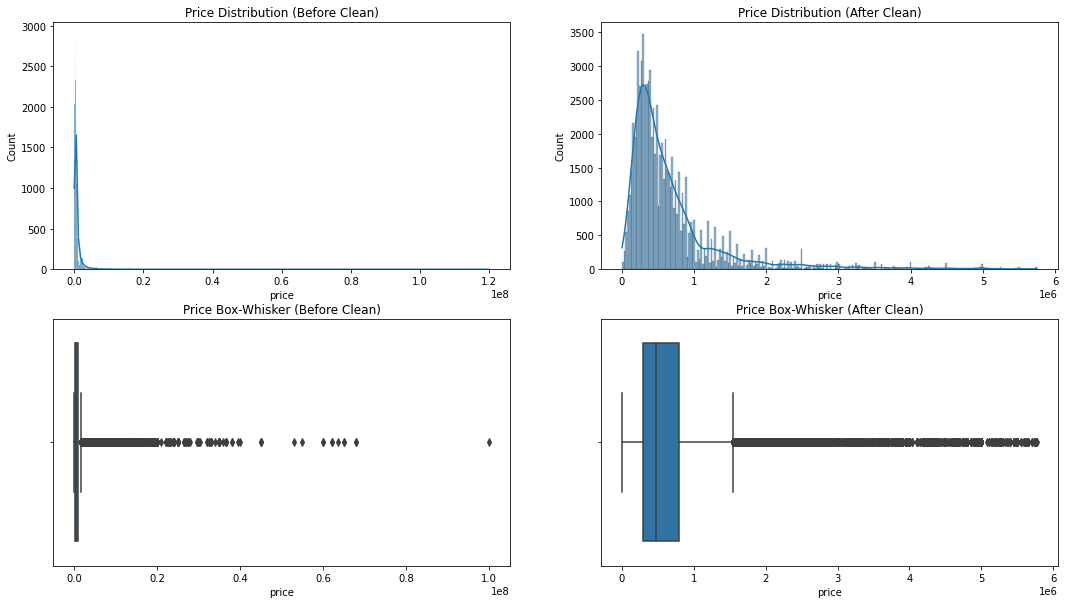

In [125]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].set_title('Price Distribution (Before Clean)')
sns.histplot(df_raw.sample(n=80000)['price'], kde=True, ax=axes[0,0]);

axes[1,0].set_title('Price Box-Whisker (Before Clean)')
sns.boxplot(x=df_raw.sample(n=80000)['price'],ax=axes[1,0]);

axes[0,1].set_title('Price Distribution (After Clean)')
sns.histplot(df.sample(n=80000)['price'], kde=True, ax=axes[0,1]);

axes[1,1].set_title('Price Box-Whisker (After Clean)')
sns.boxplot(x=df.sample(n=80000)['price'], ax=axes[1,1]);

In [106]:
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Null_Count'})

Null_Count
status                   0
bed                      0
bath                     0
acre_lot            161664
city                    15
state                    0
zip_code                 3
house_size               0
prev_sold_date      236661
price                    0
population            1213

In [ ]:
#Engineer Days since prev_sold and peep corr

## EDA
- _Univariate_ Analysis of Price
- _Bivariate_ Analysis
- Correlation
- Sig. Testing

#### Distributions, Correlation, Multidimensional Viz 

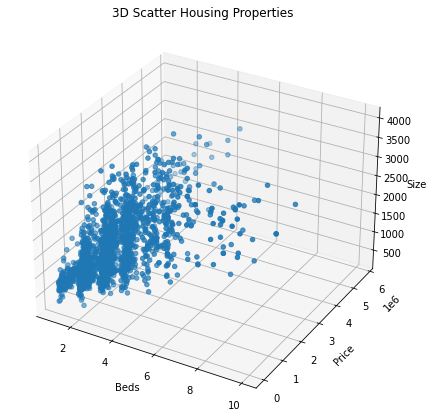

In [107]:
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

sampled_df = df.sample(n=2000) #Sample df for Viz

ax.scatter(sampled_df['bed'], sampled_df['price'], sampled_df['house_size'])

ax.set_xlabel('Beds')
ax.set_ylabel('Price')
ax.set_zlabel('Size')
ax.set_title('3D Scatter Housing Properties')
plt.show()

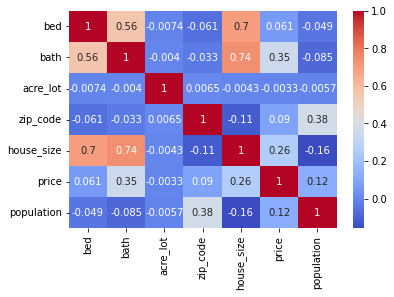

In [108]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True);

## K-means Clustering 

In [111]:
#Import Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [117]:
df.reset_index(inplace=True)
df_k = df.copy() #df for K-means processes

### _Normalize Features_

In [122]:
df_k.head(2)

index    status  bed  bath  acre_lot    city          state  zip_code  \
0  24231  for_sale  2.0   1.0      0.34  Agawam  Massachusetts    1001.0   
1  24233  for_sale  2.0   2.0       NaN  Agawam  Massachusetts    1001.0   

   house_size prev_sold_date     price  population   price_T  house_size_t  
0       676.0            NaN  180000.0     16769.0 -0.704005     -1.323323  
1       892.0     2019-04-30  169900.0     16769.0 -0.717769     -1.050557

In [136]:
scaler = StandardScaler() #Z-Scores 
df_k[['price_T', 'house_size_t', 'bath_t']] = scaler.fit_transform(df_k[['price', 'house_size', 'bath']])

### _Elbow Function_

In [123]:
def elbow(data, max_k): #Identify optimal K value respecting SSE
    k_vals = []
    sse = []
    
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        k_vals.append(k)
        sse.append(kmeans.inertia_)
        
    #Elbow Plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(k_vals, sse, 'o-')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.grid(True)
    plt.show()

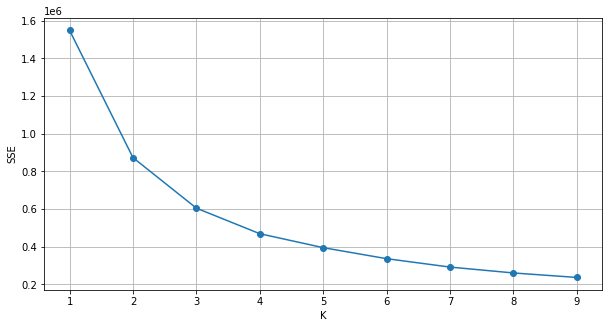

In [151]:
elbow(df_k[['price_T', 'house_size_t', 'bath_t']], 10) #View up to 10 k-values

### _K-means Application_
- `k = 3`
- `vars = price, house_size`

In [161]:
kmeans = KMeans(n_clusters=3) #Fit data to Kmeans Algo
kmeans.fit(df_k[['price_T', 'house_size_t']])

KMeans(n_clusters=3)

In [162]:
df_k['kmeans_3'] = kmeans.labels_

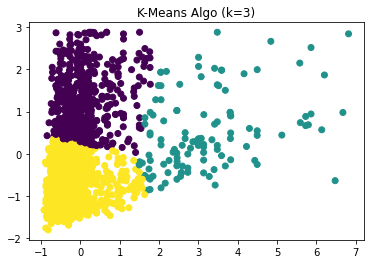

In [165]:
df_k_sampled = df_k.sample(2000)
plt.scatter(df_k_sampled['price_T'], df_k_sampled['house_size_t'], c=df_k_sampled['kmeans_3'])
plt.title('K-Means Algo (k=3)');

- `k = 4`
- `vars = price, house_size`

In [158]:
kmeans = KMeans(n_clusters=4) #Fit data to Kmeans Algo
kmeans.fit(df_k[['price_T', 'bath_t', 'house_size_t']])
df_k['kmeans_3_multi'] = kmeans.labels_

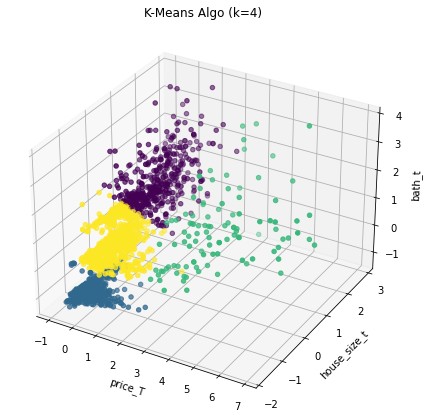

In [160]:
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

df_k_sampled = df_k.sample(2000) #Sample df for Viz

ax.scatter(df_k_sampled['price_T'], df_k_sampled['house_size_t'], df_k_sampled['bath_t'], c=df_k_sampled['kmeans_3_multi'])

ax.set_xlabel('price_T')
ax.set_ylabel('house_size_t')
ax.set_zlabel('bath_t')
ax.set_title('K-Means Algo (k=4)')
plt.show()